# Python для сбора и анализа данных

*Алла Тамбовцева*

## Практикум 7.2. Управление браузером с Selenium: пример Кинопоиска

Импортируем необходимые компоненты Selenium, а также функцию `BeautifulSoup`:

In [1]:
from selenium import webdriver as wd
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

from bs4 import BeautifulSoup

Открываем браузер – начинаем новую сессию работы с Selenium:

In [2]:
br = wd.Chrome()

Отправляем запрос – открываем главную страницу Кинопоиска в новом окне браузера:

In [3]:
# чудеса вышкинского вайфая, если капча не вылезает
# если вылезла – проходим ее вручную, тыкаем на галочку и вводим текст

br.get("https://www.kinopoisk.ru/")

Почти со 100% уверенностью Кинопоиск покажет капчу, мы поступим не самым спортивным, но бесплатным способом – вручную пройдем ее в открытом через Selenium окне браузера. Вообще самый надежный и универсальный способ обхода – установить специальное расширение и получить доступ к сервисам типа AntiCapcha или Antigate, а потом активировать это расширение при открытии браузера через Selenium. Но эти сервисы платные, хоть и не очень дорогие.

В нашем случае проблема с капчей не такая уж и глобальная, если мы пишем код для себя. Если мы все-таки пишем код для другого пользователя или вообще готовим какое-то приложение, тут есть о чем подумать еще помимо капчи, например, о том, как пользователям безболезненно установить все для Selenium или как разместить драйвер для Chrome (и сам Chrome) на сервере...

Ищем на странице поле для поиска фильма, судя по его виду (проверить можно, открыв исходный код страницы), оно будет иметь тэг `<input>`:

In [4]:
search = br.find_element(By.TAG_NAME, "input")

Введём в найденное поле ключевые слова для поиска – название фильма:

In [5]:
film = "Господин оформитель"
search.send_keys(film)

Если проверить, в окне браузера в строке поиска должно появиться название фильма. Чтобы активировать поиск, надо выбрать в выпадающем меню подходящее название и кликнуть на него. Но мы поступим проще – имитируем нажатие *Enter* через коллекцию методов `Keys` и тот же метод `.send_keys()`:

In [6]:
search.send_keys(Keys.ENTER)

Отлично! Результаты появились. Единственный минус – фильм не один. Найдем тот, который нам нужен, по совпадению текста ссылки (ссылки на фильмы содержат сами ссылки в виде адресов и текст):

In [7]:
link = br.find_element(By.LINK_TEXT, film)

Объект найден, кликаем на него:

In [8]:
link.click()

Страница фильма открыта. Давайте получим данные, на основе которых на сайте строятся графики, визуализирующие распределение оценок фильмов. Для этого сначала найдем ссылку, которую ведет на страницу с оценками. Если изучить исходный код страницы, можно заметить, что эта ссылка, как и все ссылки, имеет тэг `<a>`, но отличается тем, что имеет атрибут `class` со значением `film-rating-value styles_root__iV6le styles_rootLink__mm0kW`. Для разнообразия найдем ссылку с помощью XPATH:

In [9]:
# ищем и кликаем
rating = br.find_element(By.XPATH, 
                         "//a[@class = 'film-rating-value styles_root__iV6le styles_rootLink__mm0kW']")
rating.click()

В браузере открыта страница с оценками фильма. Давайте извлечём исходный код HTML, преобразуем его в объект `BeautifulSoup` и найдём в нем фрагмент, содержащий ссылку на данные, на основе которых строится круговая диаграмма.

In [10]:
html = br.page_source
soup = BeautifulSoup(html)

Если внимательно изучим исходный код страницы, заметим, что ссылка на нужные данные хранится во фрагменте кода на JavaScript. Найдем его и заберем весь текст оттуда (атрибут `.text`):

In [12]:
# индекс 12 или 13, у кого как

code = soup.find_all("script", {"type" : "text/javascript"})[13].text
print(code)


$(function () {
    $('#flashcontent_2').css({
        marginTop: 20,
        width: 500,
        height: 330,
    });
    KPChart.create({
        containerId: 'flashcontent_2',
        chartType: 'pie',
        dataURI: 'https://kinopoisk-fvs.s3.yandex.net/films/44587/value-stats.json',
        dataType: 'json',
        pie: {
            minRadius: 110,
            innerRadius: 25,
            depth3D: 20,
            angle: 25,
            labelRadius: 30,
            startDuration: 0,
            pulledField: 'out',
            hideLabelsPercent: 3,
            descriptionField: null,
            colors: [
                '#FF0F00',
                '#FF6600',
                '#FF9E01',
                '#FCD202',
                '#F8FF01',
                '#B0DE09',
                '#04D215',
                '#0D8ECF',
                '#0D52D1',
                '#2A0CD0'
            ]
        },
        legend: {
            position: 'absolute',
            left: '10px',
        

В переменной code хранится обычная строка, объект типа `string`. Так это не блок кода HTML, поиск по тэгам здесь невозможен. Воспользуемся регулярными выражениями – найдем все ссылки, который заканчиваются на `.json`:

In [13]:
import re

# начало и конец ссылки известны
# между https: и .json сколько угодно символов (.+)
# точка перед json экранируется

data_link = re.findall("https:.+\.json", code)[0]
data_link

'https://kinopoisk-fvs.s3.yandex.net/films/44587/value-stats.json'

Ура, ссылка найдена! Отправляем её в браузер, окно которого у нас все еще открыто, благодаря Selenium, и снова забираем исходный код (уже последний раз).

In [14]:
br.get(data_link)
page = br.page_source
page

'<html><head><meta name="color-scheme" content="light dark"></head><body><pre style="word-wrap: break-word; white-space: pre-wrap;">[{"value":263,"title":"1","out":null},{"value":145,"title":"2","out":null},{"value":205,"title":"3","out":null},{"value":313,"title":"4","out":null},{"value":745,"title":"5","out":null},{"value":1262,"title":"6","out":null},{"value":2195,"title":"7","out":"true"},{"value":2083,"title":"8","out":null},{"value":1079,"title":"9","out":null},{"value":1705,"title":"10","out":null}]</pre></body></html>'

В данном случае проще не преобразовывать исходный код в объект `BeautifulSoup`, поэтому с помощью регулярных выражений найдем фрагмент, который содержит данные в формате JSON-строки (как будто список со словарями):

In [16]:
# как список словарей, только в тексте
# ищем в строке page все фрагменты с квадратными скобками
# скобки [ и ] экранируем, между ними – сколько угодно символов

data_str = re.findall("\[\{.+\}\]", page)[0]
data_str

'[{"value":263,"title":"1","out":null},{"value":145,"title":"2","out":null},{"value":205,"title":"3","out":null},{"value":313,"title":"4","out":null},{"value":745,"title":"5","out":null},{"value":1262,"title":"6","out":null},{"value":2195,"title":"7","out":"true"},{"value":2083,"title":"8","out":null},{"value":1079,"title":"9","out":null},{"value":1705,"title":"10","out":null}]'

Теперь импортируем модуль `json`, который позволит преобразовать эту JSON-строку в полноценный список словарей, принятый в Python:

In [17]:
import json

В этом модуле есть две функции: `load()` загружает данные из текстового файла с расширением `.json`, а `loads()` загружает данные из строки в формате JSON:

In [18]:
data_dict = json.loads(data_str)
data_dict

[{'value': 263, 'title': '1', 'out': None},
 {'value': 145, 'title': '2', 'out': None},
 {'value': 205, 'title': '3', 'out': None},
 {'value': 313, 'title': '4', 'out': None},
 {'value': 745, 'title': '5', 'out': None},
 {'value': 1262, 'title': '6', 'out': None},
 {'value': 2195, 'title': '7', 'out': 'true'},
 {'value': 2083, 'title': '8', 'out': None},
 {'value': 1079, 'title': '9', 'out': None},
 {'value': 1705, 'title': '10', 'out': None}]

Полноценный список словарей получен, далее превратим его в датафрейм pandas и построим кольцевую диаграмму для распределения оценок!

In [19]:
import pandas as pd
from matplotlib import pyplot as plt

In [21]:
df = pd.DataFrame(data_dict)

In [22]:
df

,value,title,out
0,263,1,None
1,145,2,None
2,205,3,None
3,313,4,None
4,745,5,None
5,1262,6,None
6,2195,7,true
7,2083,8,None
8,1079,9,None
9,1705,10,None


In [23]:
x = df["title"].values
y = df["value"].values

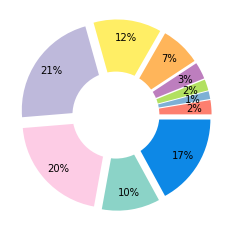

In [24]:
# список цветов для примера

cc = ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a",
      "#ffee65", "#beb9db", "#fdcce5", "#8bd3c7", "#0d88e6"]

# рисуем белый круг
centre_circle = plt.Circle((0, 0), 0.5, fc = 'white')

# рисуем диаграмму pie chart:
# y – частоты
# autopct – добавляем подписи с процентами, формат integer %i
# pctdistance – насколько подипси с процентами должны быть удалены от центра круга
# explode – ширина зазора между секторами

plt.pie(y,
        colors = cc,
        autopct = '%i%%',
        pctdistance = 0.8,
        explode = [0.1] * 10)

# добавляем круг на pie chart
plt.gca().add_artist(centre_circle);

Тот же график и с названиями категорий (оценки), и с процентами:

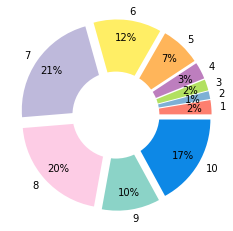

In [25]:
centre_circle = plt.Circle((0, 0), 0.5, fc = 'white')

# labels = x

plt.pie(y,
        colors = cc,
        labels = x,
        autopct = '%i%%',
        pctdistance = 0.8,
        explode = [0.1] * 10)

plt.gca().add_artist(centre_circle);

Тот же график в более крупном виде и с легендой вне картинки:

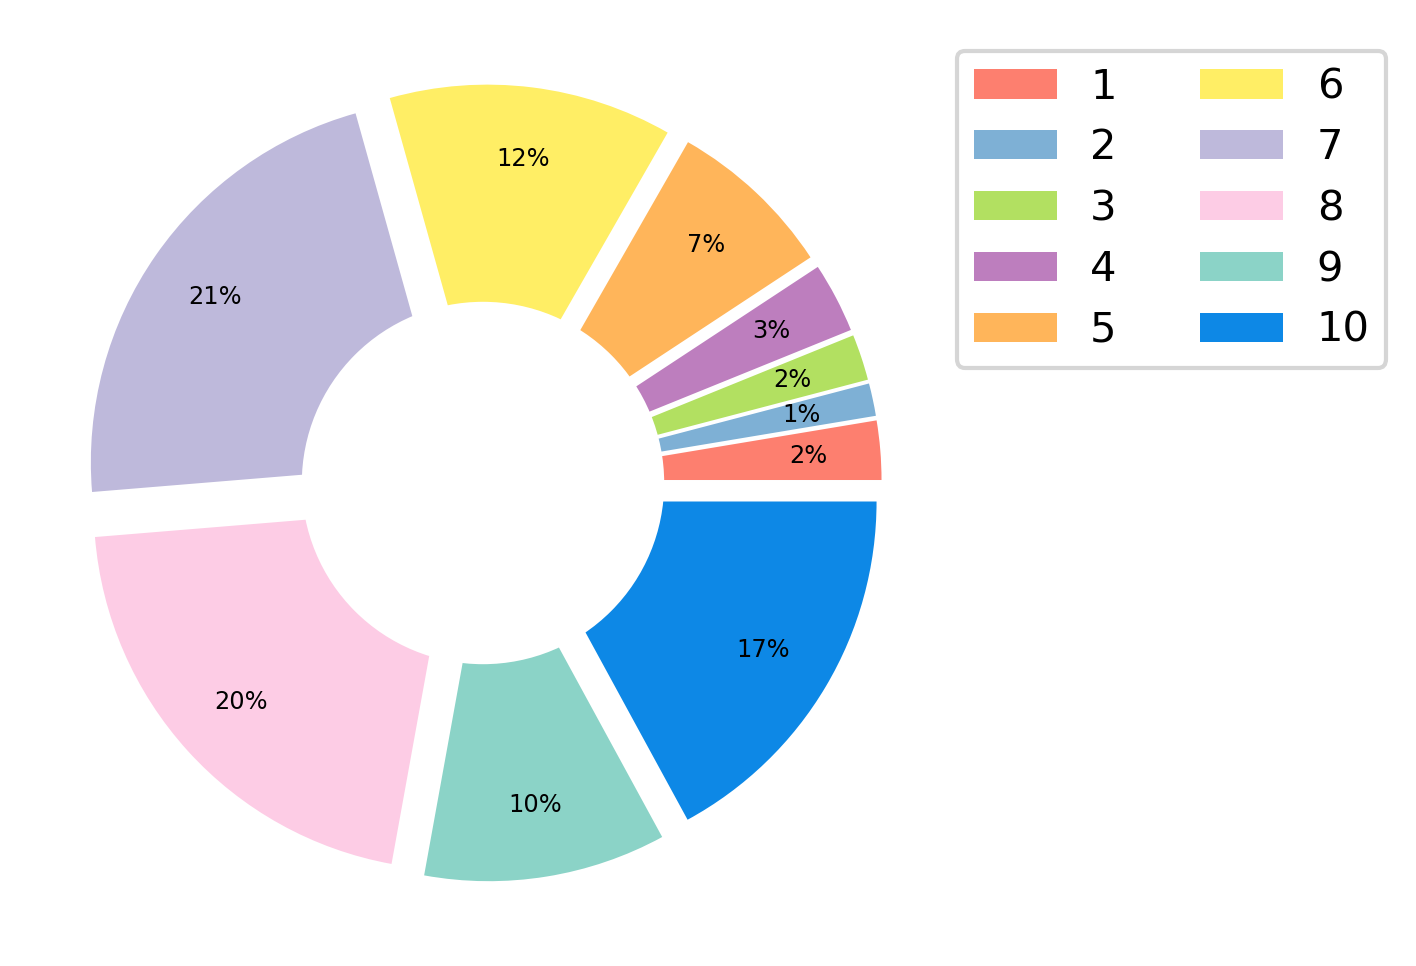

In [43]:
fig, ax = plt.subplots(dpi = 300)

centre_circle = plt.Circle((0, 0), 0.5, fc = 'white')

# labels уже нет, перенесли их в легенду
# сделали шрифт подписей поменьше через textprops

ax.pie(y,
        colors = cc,
        autopct = '%i%%',
        textprops = {"fontsize" : "xx-small"},
        pctdistance = 0.8,
        explode = [0.1] * 10)

plt.gca().add_artist(centre_circle);

# легенда
# x – названия категорий (сами оценки)
# loc – позиция легенды
# bbox_to_anchor – сдвиг относительно графика во избежание наложений
# ncol – два столбца в легенде

ax.legend(x, 
          loc = 'upper left', 
          bbox_to_anchor = (1, 1),
          ncol = 2, 
          fancybox = True);

fig.savefig("pie.png")

Но вообще для таких данных лучше столбиковую диаграмму взять или объединить оценки менее 4 в одну категорию. Все 10 категорий многовато, плюс, есть редкие значения, отсюда совсем узкие сектора и не очень удачная диаграмма.